In [ ]:
# pip install open-metric-learning==2.1.8

In [1]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import random
from IPython.display import clear_output

import gc

from oml.datasets.base import DatasetQueryGallery, DatasetWithLabels
from oml.losses.triplet import TripletLossWithMiner
from oml.metrics.embeddings import EmbeddingMetrics
from oml.miners.inbatch_all_tri import AllTripletsMiner
from oml.miners.cross_batch import TripletMinerWithMemory
from oml.models import ViTExtractor, ViTUnicomExtractor, ViTCLIPExtractor, ResnetExtractor
from oml.samplers.category_balance import CategoryBalanceSampler
from oml.samplers.balance import BalanceSampler
from oml.registry.transforms import get_transforms_for_pretrained

In [2]:
SEED = 60

def set_seed():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES']= '1'
    
device = "cpu"

if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)

cuda:0


In [3]:
# load dataframe
dataset_root = "/kaggle/input/avito-fashion-dataset"
train_df = pd.read_csv("/kaggle/input/avito-data/one_buyer_contact_labeles_oml_FULL_TRAIN.csv")
val_df = pd.read_csv("/kaggle/input/avito-data/one_buyer_contact_labeles_oml_FULL_VAL.csv")

In [4]:
train_df["path"] = train_df["image_id"].apply(lambda x: "avito_fashion_images/images/" + str(x) + ".jpg")
val_df["path"] = val_df["image_id"].apply(lambda x: "avito_fashion_images/images/" + str(x) + ".jpg")

In [5]:
val_df.head()

,buyer_id,item_id,category,image_id,label,is_query,is_gallery,split,path
0,2966783924798104,3938927327,Обувь,27672233269,19,True,True,validation,avito_fashion_images/images/27672233269.jpg
1,2966783924798104,3865044204,Обувь,26906323202,19,True,True,validation,avito_fashion_images/images/26906323202.jpg
2,2966783924798104,4007065225,Обувь,27771490866,19,True,True,validation,avito_fashion_images/images/27771490866.jpg
3,2966783924798104,3733313164,Обувь,26908757984,19,True,True,validation,avito_fashion_images/images/26908757984.jpg
4,2966783924798104,3974800432,Обувь,27528881076,19,True,True,validation,avito_fashion_images/images/27528881076.jpg


In [6]:
val_df = val_df.groupby("label").filter(lambda x: x.shape[0] != 1).reset_index(drop=True)
val_df.groupby("label").count().min()

buyer_id      2
item_id       2
category      2
image_id      2
is_query      2
is_gallery    2
split         2
path          2
dtype: int64

# Оценка предварительно обученных моделей на валидации

* "vits16_inshop": cmc@1 - 4.3%, cmc@8 - 8.3%, map@8 -5.3%
* "resnet50_imagenet1k_v1": cmc@1 - 6.2%, cmc@8 - 15.8%, map@8 -8.8%
* "vitb8_dino": cmc@1 - 12.2%, cmc@8 - 27.4%, map@8 -16.2%
* "openai_vitb16_224": cmc@1 - 15.2%, cmc@8 - 36.7%, map@8 -20.8%
* "vitb32_unicom": cmc@1 - 19.7%, cmc@8 - 41.0%, map@8 -25.2%
* "vitl14_unicom": cmc@1 - 26.8%, cmc@8 - 51.6%, map@8 -33.0%

In [ ]:
model_list = ["resnet50_imagenet1k_v1", "vits16_inshop", "vitb8_dino", "openai_vitb16_224", "vitb32_unicom", "vitl14_unicom"]
model = "vitb32_unicom"
# extractor = ViTExtractor.from_pretrained(model).to(device) # for "vits16_inshop", "vitb8_dino"
# extractor = ViTCLIPExtractor.from_pretrained(model).to(device)
extractor = ViTUnicomExtractor.from_pretrained(model).to(device)
# extractor = ResnetExtractor.from_pretrained(model).to(device)


transforms, im_reader = get_transforms_for_pretrained(model)


In [ ]:
extractor.to("cpu")
del extractor
gc.collect()
torch.cuda.empty_cache()

In [ ]:
set_seed()

In [ ]:
val_dataset = DatasetQueryGallery(
    val_df, 
    dataset_root=dataset_root,
    transform=transforms
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=64,    
#     num_workers=4, 
    pin_memory=True, 
#     prefetch_factor=16,
#     pin_memory_device="cuda",
#     persistent_workers=True
)
calculator = EmbeddingMetrics(
    extra_keys=("paths",),
    cmc_top_k=(1, 8), 
    precision_top_k=(1, 8), 
    map_top_k=(1, 8),
)
calculator.setup(num_samples=len(val_dataset))

with torch.no_grad():
    for batch in tqdm(val_loader):
        batch["embeddings"] = extractor(batch["input_tensors"].cuda(non_blocking=True)).to("cpu")
        calculator.update_data(batch)
metrics = calculator.compute_metrics()

In [ ]:
# Logging
print(calculator.metrics)  # metrics
print(calculator.metrics_unreduced)  # metrics without averaging over queries

In [ ]:
# Visualisation
fig = calculator.get_plot_for_queries(query_ids=[207, 212, 237, 633, 392, 932], n_instances=5, verbose=False);  # draw predictions on predefined queries

In [ ]:
fig.savefig(f'{model}_example.png')

In [ ]:
# Visualisation
calculator.get_plot_for_queries(query_ids=[0, 2], n_instances=5);  # draw predictions on predefined queries

In [ ]:
calculator.get_plot_for_worst_queries(metric_name="OVERALL/map/8", n_queries=2, n_instances=5);  # draw mistakes

In [ ]:
calculator.visualize();  # draw mistakes for all the available metrics

## Дообучение на данных Авито

In [ ]:
def plot_progress(lrs, train_losses, val_metrics, loss=''):
    clear_output(True)

    f, ax = plt.subplots(nrows=1, ncols=5)
    f.set_figheight(6)
    f.set_figwidth(20)

    ax[0].plot(train_losses, label='train loss')
#     ax[0].plot(val_losses, label='val loss')
    ax[0].plot(np.zeros_like(train_losses), '--', label='zero')
    ax[0].set_title('Loss')
#     ax[0].set_ylabel(loss)
    ax[0].set_xlabel('Epoch number')
    ax[0].legend()
    
    ax[1].plot(lrs, label='learning rate')
    ax[1].set_title('Learing rate')
    ax[1].set_xlabel('Batch number')
    ax[1].legend()
    
    i = 2
    for metric in val_metrics:
        if "_8" in metric: 
            ax[i].plot(val_metrics[metric], label=f'val metric {np.round(val_metrics[metric][0], 3)}')
            ax[i].set_title(metric)
            ax[i].set_xlabel('Epoch number')
            ax[i].legend()
            i += 1 

    plt.show()
    
    f.savefig(f'metric_with_hardminer_epoch{len(train_losses)}.png')
    
    
def plot_batch_progress(train_losses):
    clear_output(True)

    f, ax = plt.subplots(nrows=1, ncols=1)

    ax.plot(train_losses, label='train loss')
    ax.plot(np.zeros_like(train_losses), '--', label='zero')
    ax.set_title('Loss')
    ax.set_xlabel('each 50th batch')
    ax.legend()

    plt.show()


def train_epoch(loader, model, optimizer, criterion, lrs, scheduler=None):
    model.train()
    avg_loss = 0
    each_loss = [0,]
    scores = []
    optimizer.zero_grad()
    batch_num = 0
    for batch in tqdm(loader):
        embeddings = model(batch["input_tensors"].cuda(non_blocking=True))
        loss = criterion(embeddings, batch["labels"].cuda(non_blocking=True))
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        lrs.append(optimizer.param_groups[0]["lr"])
        optimizer.zero_grad()
        
        # iter loss
        avg_loss += loss.item()
        each_loss[-1] += loss.item()
        
        batch_num += 1
        
        if batch_num % 50 == 0:
            each_loss[-1] /= 50
            plot_batch_progress(each_loss)
            each_loss.append(0)
        
    avg_loss /= len(loader)
    return avg_loss, lrs


def valid_epoch(loader, model, criterion, _len):
    model.eval()
    calculator = EmbeddingMetrics(
        extra_keys=("paths",), 
        return_only_overall_category=True,
        cmc_top_k=(1, 8),
        map_top_k=(1, 8),
        precision_top_k=(1, 8),
        verbose=False,
    )
    scores = {
        "cmc": [],
        "precision": [],
        "map": []
    }
    calculator.setup(num_samples=_len)
    with torch.no_grad():
        for batch in tqdm(loader):
            embeddings = model(batch["input_tensors"].cuda(non_blocking=True))
            # item metric
            batch["embeddings"] = embeddings.to("cpu")
            calculator.update_data(batch)

    metrics = calculator.compute_metrics()
    scores["cmc"].append(metrics["OVERALL"]["cmc"])
    scores["precision"].append(metrics["OVERALL"]["precision"])
    scores["map"].append(metrics["OVERALL"]["map"])
    return scores

In [ ]:
from oml.miners.inbatch_hard_tri import HardTripletsMiner

In [ ]:
extractor = ViTUnicomExtractor.from_pretrained("vitb32_unicom").to(device)
transforms, im_reader = get_transforms_for_pretrained("vitb32_unicom")

train_dataset = DatasetWithLabels(
    train_df, 
    dataset_root=dataset_root,
    transform=transforms
)
train_sampler = CategoryBalanceSampler(
    labels=train_dataset.get_labels(), 
    label2category=train_dataset.get_label2category(),
    n_labels=10, 
    n_instances=8, 
    n_categories=1,
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_sampler=train_sampler, 
    pin_memory=True,
)

val_dataset = DatasetQueryGallery(
    val_df, 
    dataset_root=dataset_root,
    transform=transforms # get_normalisation_resize_torch(im_size=224) # 
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,  
    batch_size=64,    
#     num_workers=4, 
#     pin_memory=True, 
#     prefetch_factor=16,
# #     pin_memory_device="cuda",
#     persistent_workers=True
)

optimizer = torch.optim.Adam(extractor.parameters(), lr=1e-6)
criterion = TripletLossWithMiner(margin=0.1, miner=HardTripletsMiner(), need_logs=True) #TripletMinerWithMemory AllTripletsMiner
loss_name = "TripletLossWithMiner, margin=0.1"

n_epochs = 20

In [ ]:
set_seed()
PATH_MODELS = '/kaggle/working/'
best_score = 0.
lrs = []
train_losses, valid_losses = [], []
valid_scores = {
    "cmc_1": [],
    "precision_1": [],
    "map_1": [],
    "cmc_8": [],
    "precision_8": [],
    "map_8": []
}

for epoch in range(n_epochs):
    train_loss, lrs = train_epoch(train_loader, extractor, optimizer, criterion, lrs)
    valid_score = valid_epoch(val_loader, extractor, criterion, len(val_dataset))

    train_losses.append(train_loss)
#     valid_losses.append(valid_loss)
    
    valid_scores["cmc_8"].append(valid_score["cmc"][0][8].item())
    valid_scores["precision_8"].append(valid_score["precision"][0][8].item())
    valid_scores["map_8"].append(valid_score["map"][0][8].item())
    
#     valid_scores["cmc_1"].append(valid_score["cmc"][0][1].item())
#     valid_scores["precision_1"].append(valid_score["precision"][0][1].item())
#     valid_scores["map_1"].append(valid_score["map"][0][1].item())

    plot_progress(lrs, train_losses, valid_scores, loss=loss_name)

    if valid_score["cmc"][0][8].item() > best_score:
        torch.save(extractor, f'{PATH_MODELS}/train_extractor_hardminer.pth')
        best_score = valid_score["cmc"][0][8].item()

## Оценка дообученной модели

* "vitb32_unicom": cmc@1 - 19.7%, cmc@8 - 41.0%, map@8 -25.2%
* "vitb32_unicom" + triplet + allminer: cmc@1 - 23.5%, cmc@8 - 48.3%, map@8 -29.7%
* "vitb32_unicom" + triplet + hardminer: cmc@1 - 25.3%, cmc@8 - 49.0%, map@8 -35.1%

In [9]:
from torch import load
my_extractor = load('/kaggle/working/train_extractor_hardminer.pth').to(device)
transforms, im_reader = get_transforms_for_pretrained("vitb32_unicom")

In [10]:
val_dataset = DatasetQueryGallery(
    val_df, 
    dataset_root=dataset_root,
    transform=transforms
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=64,    
#     num_workers=4, 
    pin_memory=True, 
#     prefetch_factor=16,
#     pin_memory_device="cuda",
#     persistent_workers=True
)
calculator = EmbeddingMetrics(
    extra_keys=("paths",),
    cmc_top_k=(1, 8), 
    precision_top_k=(1, 8), 
    map_top_k=(1, 8),
)
calculator.setup(num_samples=len(val_dataset))

with torch.no_grad():
    for batch in tqdm(val_loader):
        batch["embeddings"] = my_extractor(batch["input_tensors"].cuda(non_blocking=True)).to("cpu")
        calculator.update_data(batch)
metrics = calculator.compute_metrics()

  0%|          | 0/70 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 70/70 [00:17<00:00,  4.11it/s]



Metrics:
{'OVERALL': {'cmc': {1: tensor(0.2549), 8: tensor(0.4885)},
             'map': {1: tensor(0.2549), 8: tensor(0.3141)},
             'pcf': {0.5: tensor(0.2051)},
             'precision': {1: tensor(0.2549), 8: tensor(0.3478)}}}


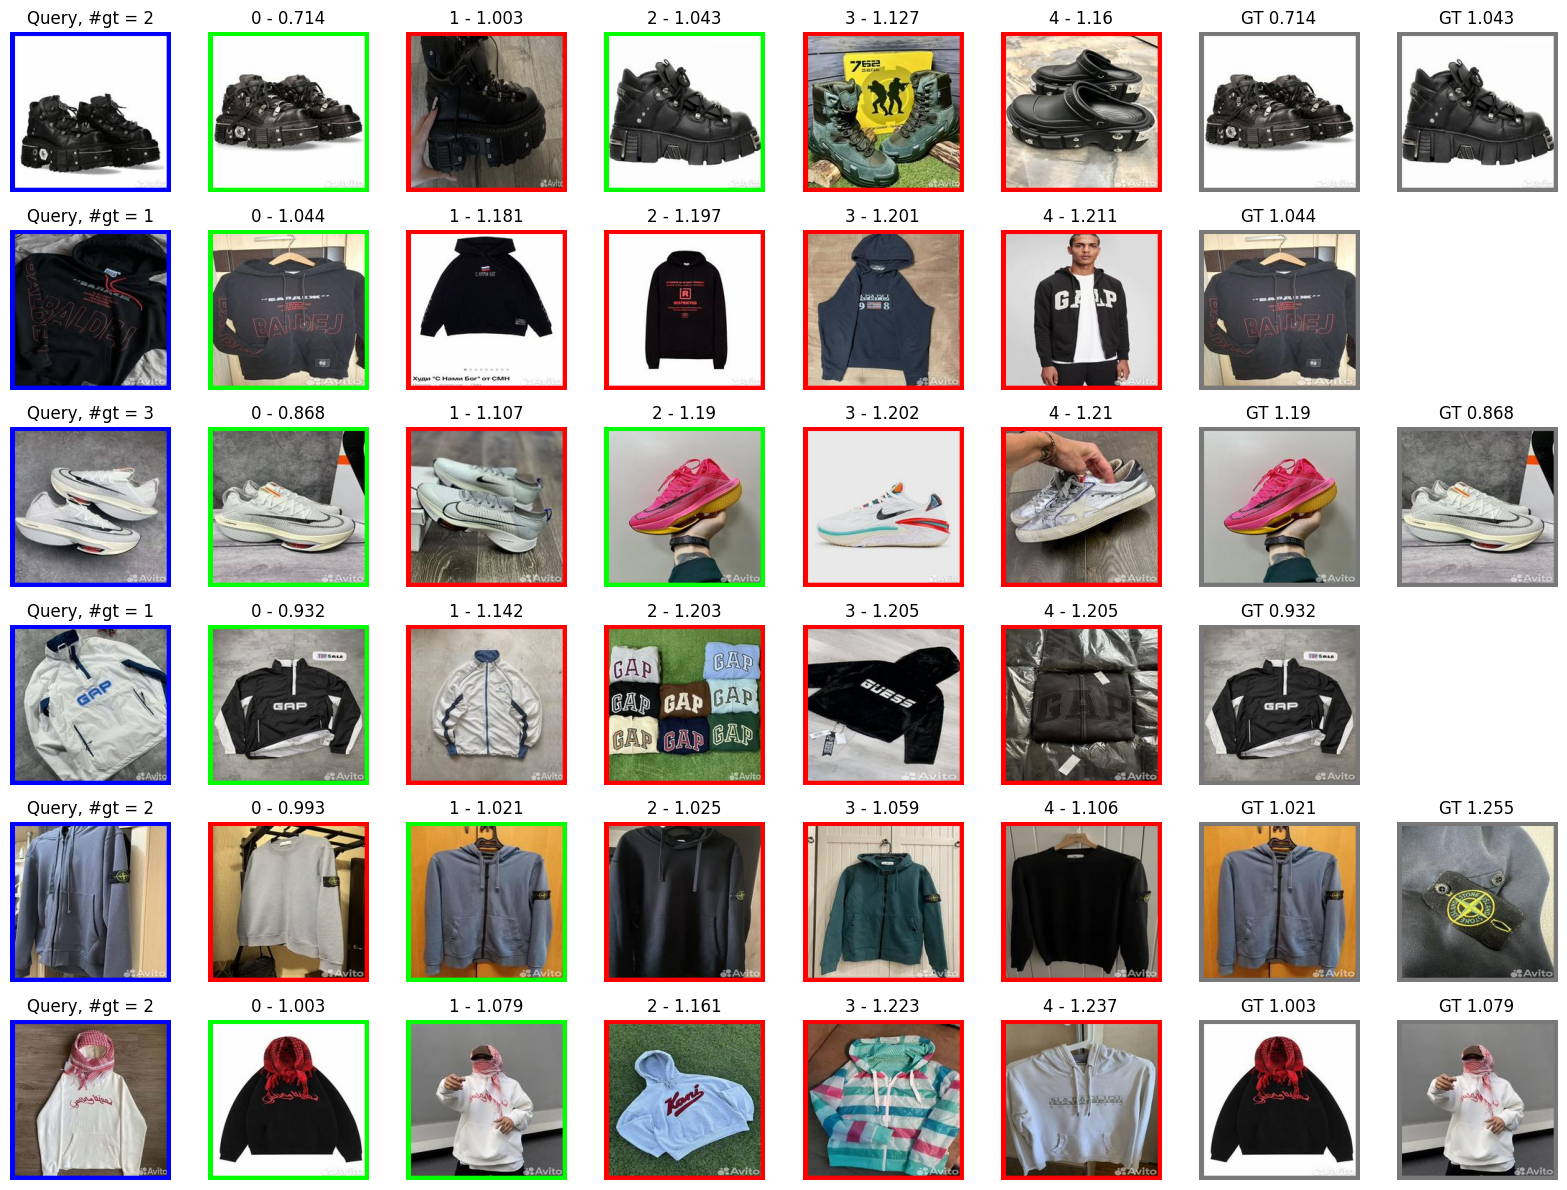

In [11]:
fig = calculator.get_plot_for_queries(query_ids=[207, 212, 237, 633, 392, 932], n_instances=5, verbose=False);  # draw predictions on predefined queries

In [ ]:
fig.savefig(f'{model}_hardminer_example.png')

In [23]:
import os
os.chdir(r'/kaggle/working')

!tar -czf allminer_model.tar.gz train_extractor_not_dict.pth

from IPython.display import FileLink

FileLink(r'allminer_model.tar.gz')

/kaggle/working/allminer_model.tar.gz